# System Algorithm
## Integration between line detection model & People detection model

### Install Libraries

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.2/876.2 kB 14.5 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib

In [ ]:
!pip install playsound

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=320dda3b1f565f6af751c5cf1a844425140077f13cf45d81a4fbdc3e9baa38dd
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


### Import Libraries

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output



### Load The Model & the video

In [ ]:
# Load the YOLO model
model = YOLO('/content/Line_detection_weights (best).pt')

# Path to your video
video_path = '/content/1020930715-preview.mp4'

### Trial 1: Danger Area Zone using Edge Detection

Detects the edges inside the bounding box of the yellow line
Issues in this approach: it detects edges of the platform itself not only the yellow line causing errors

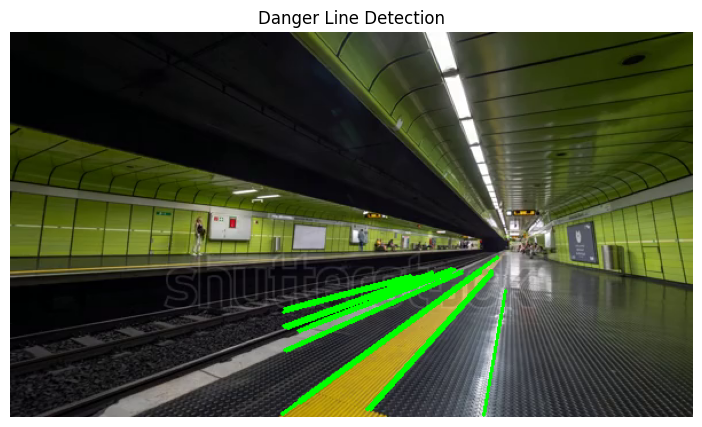

In [ ]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties for saving
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

# Function to detect yellow line points
def detect_yellow_line_points(frame, xmin, ymin, xmax, ymax):
    # Extract the ROI from the frame
    roi = frame[ymin:ymax, xmin:xmax]

    # Convert ROI to grayscale and apply Gaussian Blur
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blurred_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)

    # Canny edge detection
    edges = cv2.Canny(blurred_roi, 50, 150)

    # Use Hough Transform to find lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    detected_lines = []  # List to store detected lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Adjust coordinates to be relative to the original frame
            x1 += xmin
            y1 += ymin
            x2 += xmin
            y2 += ymin

            # Append all detected lines to the list
            detected_lines.append([(x1, y1), (x2, y2)])

    return detected_lines  # Return all detected lines

# Initialize last known points
last_lines = []

# Set frame skipping
frame_skip = 10
frame_count = 0

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Skip frames if not a multiple of frame_skip
    if frame_count % frame_skip != 0:
        frame_count += 1
        continue

    results = model(frame)

    # Check if results is empty (no detections)
    if results and results[0] is not None and len(results[0]) > 0:
        detections_found = False
        for *xyxy, conf, cls in results[0].boxes.data.tolist():
            if model.names[int(cls)] == 'stopbraille-blocks':  # Replace with your class name
                detections_found = True
                xmin, ymin, xmax, ymax = map(int, xyxy)

                # Call your function and update last known points
                lines = detect_yellow_line_points(frame, xmin, ymin, xmax, ymax)
                if lines:  # Check if lines is not empty
                    last_lines = lines

                # Draw all detected lines
                for line in last_lines:
                    cv2.line(frame, line[0], line[1], (0, 255, 0), 2)

    # If no detections found, use last known lines
    if not detections_found and last_lines:
        for line in last_lines:
            cv2.line(frame, line[0], line[1], (0, 255, 0), 2)

    # Write the frame to the output video
    out.write(frame)

    # Display the frame using matplotlib
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Danger Line Detection')
    plt.axis('off')
    plt.show()

    # Increment the frame count
    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


### Trial 2: Yellow Line Detection
Detects the yellow line inside the bounding box of the yellow line class detected previousl by yolo, after detecting the yellow line it creates a mask for it (colour segmentation)

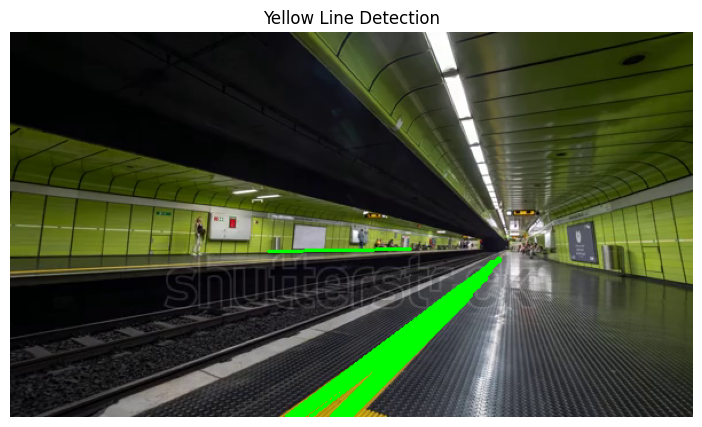

In [ ]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties for saving
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

# Function to detect yellow lines using color segmentation
def detect_yellow_line_points(frame, xmin, ymin, xmax, ymax):
    # Increase the size of the ROI slightly to capture more area
    padding = 10  # You can adjust the padding to widen the detection area
    xmin = max(0, xmin - padding)
    ymin = max(0, ymin - padding)
    xmax = min(frame.shape[1], xmax + padding)
    ymax = min(frame.shape[0], ymax + padding)

    # Extract the Region of Interest (ROI)
    roi = frame[ymin:ymax, xmin:xmax]

    # Convert the ROI to HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Adjust the HSV range to cover a broader yellow spectrum
    lower_yellow = np.array([0, 60, 100])  # Expanded yellow range to include bright and varied yellow
    upper_yellow = np.array([40, 255, 255])

    # Create a mask for yellow color
    mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)

    # Apply the mask to the ROI
    result = cv2.bitwise_and(roi, roi, mask=mask)

    # Use Hough Transform to find lines in the masked yellow region
    lines = cv2.HoughLinesP(mask, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    detected_lines = []  # List to store detected lines
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Adjust coordinates to be relative to the original frame
            x1 += xmin
            y1 += ymin
            x2 += xmin
            y2 += ymin

            # Append all detected lines to the list
            detected_lines.append([(x1, y1), (x2, y2)])

    return detected_lines  # Return all detected lines

# Initialize last known points
last_lines = []

# Set frame skipping
frame_skip = 10
frame_count = 0

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Skip frames if not a multiple of frame_skip
    if frame_count % frame_skip != 0:
        frame_count += 1
        continue

    results = model(frame)

    # Check if results is empty (no detections)
    if results and results[0] is not None and len(results[0]) > 0:
        detections_found = False
        for *xyxy, conf, cls in results[0].boxes.data.tolist():
            if model.names[int(cls)] == 'stopbraille-blocks':  # Replace with your class name
                detections_found = True
                xmin, ymin, xmax, ymax = map(int, xyxy)

                # Call your function and update last known points using color segmentation
                lines = detect_yellow_line_points(frame, xmin, ymin, xmax, ymax)
                if lines:  # Check if lines is not empty
                    print("line detected")
                    last_lines = None
                    last_lines = lines

                # Draw all detected lines
                for line in last_lines:
                    cv2.line(frame, line[0], line[1], (0, 255, 0), 2)

    # If no detections found, use last known lines
    if not detections_found and last_lines:
        for line in last_lines:
            cv2.line(frame, line[0], line[1], (0, 255, 0), 2)

    # Write the frame to the output video
    out.write(frame)

    # Display the frame using matplotlib
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Yellow Line Detection')
    plt.axis('off')
    plt.show()

    # Increment the frame count
    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


### Full Approach: Person & Line Detection
Line is detected using the 2nd idea (color segmentation), and the people and railway are detected by yolo directly
- when the people are detected at the left of the line in prescence of railway (train didn't arrive the platform) the people are annotated with red bounding box
- in the previous case people at the right are annotated with green
- if the railway is not detected (train arrived platform) all are annotated green


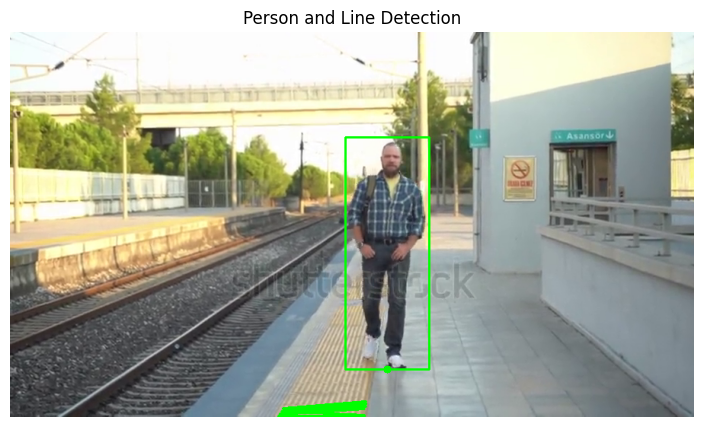

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Load the YOLO models: one for detecting the railway track, one for detecting people
line_model = YOLO('/content/Line_detection_weights (best).pt')  # Model for detecting "stopbraille-blocks" and "Railway track"
person_model = YOLO('/content/People_detection_weights(best).pt')  # Model for detecting people

# Path to your video
video_path = '/content/3505627725-preview.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties for saving
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_with_full_annotations.mp4', fourcc, fps, (width, height))

# Function to detect yellow lines inside the bounding box for "stopbraille-blocks"
def detect_yellow_line_in_stopbraille_blocks(frame, xmin, ymin, xmax, ymax):
    # Define the region of interest (ROI)
    roi = frame[ymin:ymax, xmin:xmax]

    # Convert the ROI to HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define the yellow color range in HSV
    lower_yellow = np.array([0, 60, 100])  # Adjusted for bright yellow
    upper_yellow = np.array([40, 255, 255])

    # Create a mask to extract yellow parts of the image
    mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)

    # Use Hough Transform to detect lines in the mask
    lines = cv2.HoughLinesP(mask, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    detected_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Adjust coordinates to be relative to the original frame
            x1 += xmin
            y1 += ymin
            x2 += xmin
            y2 += ymin
            detected_lines.append([(x1, y1), (x2, y2)])

    return detected_lines

# Function to get the foot position of a person
def get_foot_position(bbox):
    x1, y1, x2, y2 = bbox
    return int((x1 + x2) / 2), int(y2)

# Initialize variables
frame_count = 0
red_annotation_active = 0  # Counter to keep track of red annotation status (will be active for 20 frames)
railway_consecutive_frames = 0  # Counter for consecutive frames with railway track detection

# Variable to store the last detected yellow lines
last_yellow_lines = []

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 1. Detect "stopbraille-blocks" and "Railway track" using the line model
    line_results = line_model(frame)
    stopbraille_blocks_bbox = None
    railway_track_found = False

    if line_results and line_results[0] is not None and len(line_results[0]) > 0:
        for *xyxy, conf, cls in line_results[0].boxes.data.tolist():
            class_name = line_model.names[int(cls)]

            if class_name == 'stopbraille-blocks':  # If it's the stopbraille-blocks class
                stopbraille_blocks_bbox = list(map(int, xyxy))  # Store the bounding box (xmin, ymin, xmax, ymax)

            if class_name == 'Railway track':  # If it's the railway track class
                railway_track_found = True

    # 2. Update the railway consecutive frame counter and activate red annotation if needed
    if railway_track_found:
        railway_consecutive_frames += 1
        if railway_consecutive_frames >= 10:  # Red annotation active after 3 consecutive frames
            red_annotation_active = 20  # Activate red annotation for the next 20 frames
    else:
        railway_consecutive_frames = 0  # Reset if no railway track found

    # 3. Detect the yellow line inside the "stopbraille-blocks" bounding box (if found)
    yellow_lines = []
    if stopbraille_blocks_bbox:
        xmin, ymin, xmax, ymax = stopbraille_blocks_bbox
        yellow_lines = detect_yellow_line_in_stopbraille_blocks(frame, xmin, ymin, xmax, ymax)
        if yellow_lines:  # Update last detected lines
            last_yellow_lines = yellow_lines

    # If no yellow lines detected in this frame, use the last known yellow lines
    if not yellow_lines and last_yellow_lines:
        yellow_lines = last_yellow_lines

    # Draw the yellow line (if detected)
    for line in yellow_lines:
        cv2.line(frame, line[0], line[1], (0, 255, 0), 2)  # Draw yellow line in green for visibility

    # 4. Detect people using the person detection model
    person_results = person_model(frame)

    # 5. Process each detected person
    if len(yellow_lines) > 0 and person_results and person_results[0] is not None:
        for *xyxy, conf, cls in person_results[0].boxes.data.tolist():
            if person_model.names[int(cls)] == 'Person':  # Assuming the class name for people is 'person'
                bbox = list(map(int, xyxy))
                foot_position = get_foot_position(bbox)

                # Get the x coordinate of the yellow line (assuming we are comparing with the first detected yellow line)
                line_x1, line_y1 = yellow_lines[0][0]
                line_x2, line_y2 = yellow_lines[0][1]

                # Compare foot position to the yellow line
                if foot_position[0] > line_x1:
                    # Foot is to the right of the line, annotate in green
                    color = (0, 255, 0)  # Green
                else:
                    # Foot is to the left of the line, only annotate in red if red_annotation_active > 0
                    if red_annotation_active > 0:
                        color = (0, 0, 255)  # Red
                    else:
                        color = (0, 255, 0)  # Green (fallback)

                # Draw the bounding box for the person
                cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                cv2.circle(frame, foot_position, 5, color, -1)  # Draw foot position for reference

    # Decrease red annotation counter
    if red_annotation_active > 0:
        red_annotation_active -= 1

    # Write the frame to the output video
    out.write(frame)

    # Display the frame using matplotlib (optional)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Person and Line Detection')
    plt.axis('off')
    plt.show()

    # Increment the frame count
    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()



### Full Approach: Person & Line Detection >> version 2
Added to this version that the detection is not fixed to right and left, the model detects whether the people are crossing the line near the platform or real the raiway
>> This feature is added to handle different angles of videos

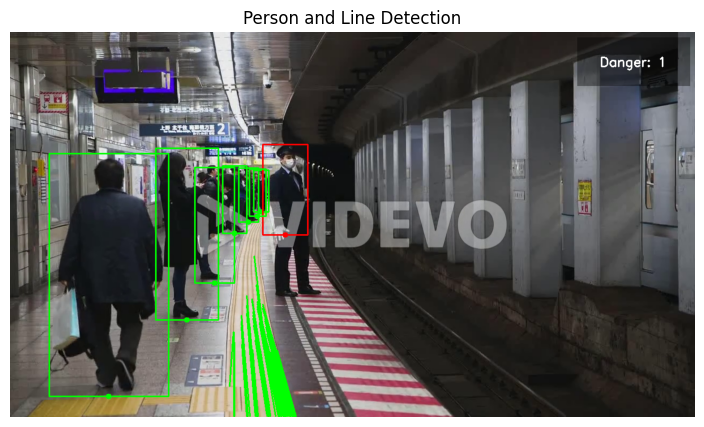

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Load the YOLO models: one for detecting the railway track, one for detecting people
line_model = YOLO('/content/best.pt')  # Model for detecting "stopbraille-blocks" and "Railway track"
person_model = YOLO('/content/best (1).pt')  # Model for detecting people

# Path to your video
video_path = '/content/BB_cff64429-bafc-4258-bdbe-6bba7270af6c_preview.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties for saving
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_with_full_annotations.mp4', fourcc, fps, (width, height))

# Function to detect yellow lines inside the bounding box for "stopbraille-blocks"
def detect_yellow_line_in_stopbraille_blocks(frame, xmin, ymin, xmax, ymax):
    # Define the region of interest (ROI)
    roi = frame[ymin:ymax, xmin:xmax]

    # Convert the ROI to HSV color space
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Define the yellow color range in HSV
    lower_yellow = np.array([0, 60, 100])  # Adjusted for bright yellow
    upper_yellow = np.array([40, 255, 255])

    # Create a mask to extract yellow parts of the image
    mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)

    # Use Hough Transform to detect lines in the mask
    lines = cv2.HoughLinesP(mask, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    detected_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Adjust coordinates to be relative to the original frame
            x1 += xmin
            y1 += ymin
            x2 += xmin
            y2 += ymin
            detected_lines.append([(x1, y1), (x2, y2)])

    return detected_lines

# Function to get the foot position of a person
def get_foot_position(bbox):
    x1, y1, x2, y2 = bbox
    return int((x1 + x2) / 2), int(y2)

# Function to add a transparent rectangle with text
def add_transparent_rectangle(frame, width, height, people_in_danger, flashing_step):
    # Coordinates for the rectangle (top-right corner)
    rect_x1 = width - 220
    rect_y1 = 10
    rect_x2 = width - 10
    rect_y2 = 100

    # Transparency level and color setting
    if people_in_danger == 0:
        # Transparent green if no one is in danger
        overlay_color = (0, 255, 0, 100)  # Green with transparency
    else:
        # Flashing red from light to dark
        red_intensity = 100 + int(155 * np.sin(flashing_step / 10.0))  # Cycle through red intensity
        overlay_color = (0, 0, red_intensity, 100)  # Flashing red with transparency

    # Create an overlay
    overlay = frame.copy()

    # Draw a filled rectangle on the overlay
    cv2.rectangle(overlay, (rect_x1, rect_y1), (rect_x2, rect_y2), overlay_color[:3], -1)

    # Apply transparency
    alpha = overlay_color[3] / 255.0
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    # Add text for the number of persons in danger
    text = f"Danger: {people_in_danger}"
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
    text_x = rect_x1 + (rect_x2 - rect_x1 - text_size[0]) // 2
    text_y = rect_y1 + (rect_y2 - rect_y1 + text_size[1]) // 2

    cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Initialize variables
frame_count = 0
red_annotation_active = 0  # Counter to keep track of red annotation status (will be active for 20 frames)
railway_consecutive_frames = 0  # Counter for consecutive frames with railway track detection
railway_track_position = None  # Store the x-coordinate of the railway track line
last_yellow_lines = []  # Variable to store the last detected yellow lines
railway_to_left = None  # Flag to store whether railway is to the left or right of yellow lines
flashing_step = 0  # Step for flashing effect

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 1. Detect "stopbraille-blocks" and "Railway track" using the line model
    line_results = line_model(frame)
    stopbraille_blocks_bbox = None
    railway_track_found = False

    if line_results and line_results[0] is not None and len(line_results[0]) > 0:
        for *xyxy, conf, cls in line_results[0].boxes.data.tolist():
            class_name = line_model.names[int(cls)]

            if class_name == 'stopbraille-blocks':  # If it's the stopbraille-blocks class
                stopbraille_blocks_bbox = list(map(int, xyxy))  # Store the bounding box (xmin, ymin, xmax, ymax)

            if class_name == 'Railway track':  # If it's the railway track class
                railway_track_found = True
                if railway_track_position is None:  # Save the first detected railway track position
                    railway_track_position = int((xyxy[0] + xyxy[2]) / 2)  # Save the midpoint of the railway track

    # 2. Update the railway consecutive frame counter and activate red annotation if needed
    if railway_track_found:
        railway_consecutive_frames += 1
        if railway_consecutive_frames >= 3:  # Red annotation active after 3 consecutive frames
            red_annotation_active = 20  # Activate red annotation for the next 20 frames
    else:
        railway_consecutive_frames = 0  # Reset if no railway track found

    # 3. Detect the yellow line inside the "stopbraille-blocks" bounding box (if found)
    yellow_lines = []
    if stopbraille_blocks_bbox:
        xmin, ymin, xmax, ymax = stopbraille_blocks_bbox
        yellow_lines = detect_yellow_line_in_stopbraille_blocks(frame, xmin, ymin, xmax, ymax)
        if yellow_lines:  # Update last detected lines
            last_yellow_lines = yellow_lines

    # If no yellow lines detected in this frame, use the last known yellow lines
    if not yellow_lines and last_yellow_lines:
        yellow_lines = last_yellow_lines

    # Draw the yellow line (if detected)
    for line in yellow_lines:
        cv2.line(frame, line[0], line[1], (0, 255, 0), 2)  # Draw yellow line in green for visibility

    # 4. Determine if the railway is to the left or right of most yellow lines (only the first time)
    if railway_track_position is not None and len(yellow_lines) > 0 and railway_to_left is None:
        # Calculate the x-coordinates of the yellow lines
        yellow_x_positions = [line[0][0] for line in yellow_lines]  # Get x-coordinates of line starts
        avg_yellow_x = np.mean(yellow_x_positions)  # Get the average x position of the yellow lines

        # Determine if railway is to the left or right (this will be done only once)
        railway_to_left = railway_track_position < avg_yellow_x

    # 5. Detect people using the person detection model
    person_results = person_model(frame)

    # 6. Process each detected person
    people_in_danger = 0  # Counter for people annotated in red

    if person_results and person_results[0] is not None:
        for *xyxy, conf, cls in person_results[0].boxes.data.tolist():
            if person_model.names[int(cls)] == 'Person':  # Assuming the class name for people is 'person'
                bbox = list(map(int, xyxy))
                foot_position = get_foot_position(bbox)

                # Initially mark all people as green
                color = (0, 255, 0)  # Green for all people initially

                # Adjust the annotation color based on the railway track and yellow line comparison
                if railway_track_position is not None and len(yellow_lines) > 0 and railway_to_left is not None:
                    if railway_to_left:
                        if foot_position[0] < avg_yellow_x:
                            if red_annotation_active > 0:
                                color = (0, 0, 255)  # Red if to the left of the yellow lines and red annotation is active
                                people_in_danger += 1  # Increment the danger counter
                        else:
                            color = (0, 255, 0)  # Green if to the right of the yellow lines
                    else:
                        if foot_position[0] > avg_yellow_x:
                            if red_annotation_active > 0:
                                color = (0, 0, 255)  # Red if to the right of the yellow lines and red annotation is active
                                people_in_danger += 1  # Increment the danger counter
                        else:
                            color = (0, 255, 0)  # Green if to the left of the yellow lines

                # Draw the bounding box for the person
                cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
                cv2.circle(frame, foot_position, 5, color, -1)  # Draw foot position for reference

    # Decrease red annotation counter
    if red_annotation_active > 0:
        red_annotation_active -= 1

    # 7. Add the transparent rectangle with danger info
    flashing_step += 5  # Increment flashing step for flashing effect

    add_transparent_rectangle(frame, width, height, people_in_danger, flashing_step)

    # Write the frame to the output video
    out.write(frame)

    # Display the frame using matplotlib (optional)
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('Person and Line Detection')
    plt.axis('off')
    plt.show()

    # Increment the frame count
    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
